# Home Loan Approval/Denial: Data preprocessing

This project aims to develop a machine learning model that can predict the approval or denial of home mortgage applications using the U.S. Home Mortgage Disclosure Act (HMDA) dataset. Individuals can utilize this model as a preliminary assessment tool before formally applying for a mortgage, while lenders can leverage it for initial screening purposes. The ultimate goal is to empower both parties with information that facilitates informed decision-making in the mortgage application process.

In this project I will be using the 2019-to-2022 data of the SF East Bay counties, namely **Alameda County** and **Contra Costa County** (California, US). The dataset can be downloaded [here](https://ffiec.cfpb.gov/data-browser/data/2022?category=states&items=CA), and [here](https://ffiec.cfpb.gov/documentation/publications/loan-level-datasets/lar-data-fields) is its documentation.

#### Imports

In [1]:
from io import StringIO
import requests
from pathlib import Path
import pandas as pd
import numpy as np

from scipy.stats import chi2_contingency

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
filename_input = 'data-hdma-eastbay-2019-2022'
filename_output = 'data-hdma-eastbay-2019-2022-preprocessed'

#### Auxiliary functions

In [4]:
def test_cuts(x, col, thr, n=4):
    """
    This function display the data grouped in bins.
    """
    display(pd.cut(x[x[col] < thr][col], bins=n).value_counts(sort=False, dropna=False))
    display(pd.qcut(x[x[col] < thr][col], q=n).value_counts(sort=False, dropna=False))

def crosstab_and_chi2(A, B):
    crosstab = pd.crosstab(index=A, columns=B)
    chi2 = chi2_contingency(crosstab)

    display(crosstab)
    print(f'{A.name} p-value={chi2[1]}')

def download_datasets():
    counties = ",".join(["06001", "06013"])  # Alameda, Contra Costa
    actions = ",".join(["1", "3"])  # Loan originated, Application denied
    dfs = []
    print("Downloading...")
    for year in [2019, 2020, 2021, 2022]:
        print(f"- year {year}")
        req = requests.get(
            f"https://ffiec.cfpb.gov/v2/data-browser-api/view/csv?years={year}&counties={counties}&actions_taken={actions}"
        )
        df = pd.read_csv(StringIO(req.text))
        dfs.append(df)
    return dfs


def open_dataset(filepath):
    file = Path(filepath)
    if file.exists() and file.stat().st_size > 1e6:
        df = pd.read_csv(filepath)
    else:
        dfs = download_datasets()
        df = pd.concat(dfs).drop_duplicates().reset_index(drop=True)
        df.to_csv(filepath, index=False)
    return df

#### Loading the raw data

Using the auxiliary functions defined above the data be loaded from the filesystem or downloaded and saved in case the file does not exist. The data is downloaded using the [FFIEC Data Browser API](https://ffiec.cfpb.gov/documentation/api/data-browser/).

In [5]:
orig_df = open_dataset(f"../../{filename_input}.csv")

/tmp/ipykernel_956282/2007743128.py:33: DtypeWarning: Columns (22,23,24,26,27,28,29,30,31,32,33,38,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


The dataset contains 616388 entries and 99 columns, and the description of the features is [documented here](https://ffiec.cfpb.gov/documentation/publications/loan-level-datasets/lar-data-fields).

Below is the info for all the columns in the raw dataset. We can see that multiple columns have a huge amount of null values, mostly the ones that are related to questions with multiple possible answers, such as race, etchnicity (of both the applicant and the co-applicant, if there is one), and the application denial reason. A few columns also should be numbers-only but contain a mix of number and strings, and will be properly converted. Also, quite a few of the numerical features are actually encoded categorical features, and they will be translated into strings using the documentation.

The main outcome of the dataset is in the `action_taken` column. All the possible values are:

- 1 - Loan originated
- 2 - Application approved but not accepted
- 3 - Application denied
- 4 - Application withdrawn by applicant
- 5 - File closed for incompleteness
- 6 - Purchased loan
- 7 - Preapproval request denied
- 8 - Preapproval request approved but not accepted

Since the main focus here is to screen through applications that are either *approved* or *denied*, I only fetch values `1` (Loan originated, application was approved), `2` (loan was approved but parties did not go through) and `3` (application denied).

In [6]:
orig_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616388 entries, 0 to 616387
Data columns (total 99 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   activity_year                             616388 non-null  int64  
 1   lei                                       616388 non-null  object 
 2   derived_msa-md                            616388 non-null  int64  
 3   state_code                                616313 non-null  object 
 4   county_code                               616388 non-null  int64  
 5   census_tract                              616170 non-null  float64
 6   conforming_loan_limit                     613507 non-null  object 
 7   derived_loan_product_type                 616388 non-null  object 
 8   derived_dwelling_category                 616388 non-null  object 
 9   derived_ethnicity                         616388 non-null  object 
 10  derived_race        

In [7]:
orig_df.head()

,activity_year,lei,derived_msa-md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,...,denial_reason-2,denial_reason-3,denial_reason-4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
0,2019,254900VHUBSJJKOMBF27,36084,CA,6001,6.001437e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,4260,85.45,111700,66,632,795,51
1,2019,254900VHUBSJJKOMBF27,36084,CA,6013,6.013392e+09,C,FHA:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,11300,80.65,111700,83,2124,2984,45
2,2019,254900VHUBSJJKOMBF27,36084,CA,6013,6.013392e+09,C,Conventional:Subordinate Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,11300,80.65,111700,83,2124,2984,45
3,2019,254900VHUBSJJKOMBF27,36084,CA,6013,6.013392e+09,C,Conventional:Subordinate Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,11300,80.65,111700,83,2124,2984,45
4,2019,254900VHUBSJJKOMBF27,36084,CA,6001,6.001434e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,5848,74.73,111700,77,1175,1413,56


In [8]:
orig_df.tail()

,activity_year,lei,derived_msa-md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,...,denial_reason-2,denial_reason-3,denial_reason-4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
616383,2022,5493000YNV8IX4VD3X12,36084,CA,6013,6.013355e+09,C,Conventional:First Lien,Single Family (1-4 Units):Manufactured,Hispanic or Latino,...,NaN,NaN,NaN,5793,66.80,142800,108,1448,1709,32
616384,2022,5493000YNV8IX4VD3X12,36084,CA,6013,6.013335e+09,C,Conventional:First Lien,Single Family (1-4 Units):Manufactured,Hispanic or Latino,...,NaN,NaN,NaN,3463,48.46,142800,94,816,1235,66
616385,2022,5493000YNV8IX4VD3X12,36084,CA,6013,6.013355e+09,C,Conventional:First Lien,Single Family (1-4 Units):Manufactured,Not Hispanic or Latino,...,7.0,NaN,NaN,4434,82.68,142800,79,808,1205,32
616386,2022,5493000YNV8IX4VD3X12,36084,CA,6013,6.013355e+09,C,Conventional:First Lien,Single Family (1-4 Units):Manufactured,Ethnicity Not Available,...,NaN,NaN,NaN,5000,26.24,142800,125,1503,1660,46
616387,2022,5493000YNV8IX4VD3X12,36084,CA,6001,6.001451e+09,C,Conventional:First Lien,Single Family (1-4 Units):Manufactured,Ethnicity Not Available,...,NaN,NaN,NaN,8901,82.44,142800,122,814,1290,28


## Cleaning the data

### First-round: Simplifying

My first step here is to do first-round of data cleaning, mostly simplifying the data by renaming some features and dropping the ones that will not be used.

Dropping:

- `activity_year`, `state_code`, `county_code`, `derived_msa-md`: constants, codes
- `lei`: I will not differentiate between the financial institutions
- `aus-*`: The automated underwriting system(s) (AUS) used by the financial institution to evaluate the application
- `_observed`: whether the information was collected on the basis of visual observation or surname
- `census_tract`
- `preapproval`: all pre-approved applications are approved

Simplifying:

- `denial-reason-*`: columns are directly related to the `Denied` applications and will not be used in the training, but are useful to analyze before modeling. I will join all reasons in one feature.
- `[co-]applicant_race-*` and `[co-]applicant_ethnicity-*`: will keep only option 1 with broader groups

Renaming:

- `action_taken` to `application_outcome`

Removing:

- all rows with `Exempt`

In [9]:
unused_columns = [
    *[x for x in orig_df.columns if x.startswith("aus-")],
    *[x for x in orig_df.columns if x.endswith("observed")],
    *[x for x in orig_df.columns if x.endswith("_credit_score_type")],
    "activity_year",
    "state_code",
    "county_code",
    "derived_msa-md",
    "lei",
    "census_tract",
    "preapproval",
    "submission_of_application",
    "manufactured_home_secured_property_type",
    "manufactured_home_land_property_interest",
    "other_nonamortizing_features",
    "negative_amortization",
    "initially_payable_to_institution",
    "ffiec_msa_md_median_family_income",
]

df = orig_df.drop(unused_columns, axis=1)
df = df[df != "Exempt"]
df = df.rename(
    columns={
        "action_taken": "application_outcome",
        "co-applicant_sex": "coapplicant_sex",
        "co-applicant_age": "coapplicant_age",
    }
)

# joining all denial_reasons
df["denial_reason"] = (
    df[[x for x in df.columns if x.startswith("denial_reason-")]]
    .replace(
        {
            1: "Debt-to-income ratio",
            2: "Employment history",
            3: "Credit history",
            4: "Collateral",
            5: "Insufficient cash",
            6: "Unverifiable information",
            7: "Credit application incomplete",
            8: "Mortgage insurance denied",
            9: "Other",
            10: "not_applicable",
        }
    )
    .apply(
        lambda x: ";".join([str(reason) for reason in x if pd.notnull(reason)]), axis=1
    )
)
df = df.drop([x for x in df.columns if x.startswith("denial_reason-")], axis=1)

# applicant race
df["applicant_race"] = (
    df[["applicant_race-1"]]
    .map(lambda x: int(str(int(x))[:1]) if pd.notnull(x) else np.nan)
    .replace(
        {
            1: "NA/PI",
            2: "Asian",
            3: "Black",
            4: "NA/PI",
            5: "White",
            6: "not_provided",
            7: "not_applicable",
        }
    )
)
df = df.drop([x for x in df.columns if x.startswith("applicant_race-")], axis=1)

# co-applicant race
df["coapplicant_race"] = (
    df[["co-applicant_race-1"]]
    .map(lambda x: int(str(int(x))[:1]) if pd.notnull(x) else np.nan)
    .replace(
        {
            1: "NA/PI",
            2: "Asian",
            3: "Black",
            4: "NA/PI",
            5: "White",
            6: "not_provided",
            7: "not_applicable",
            8: "no_coapplicant",
        }
    )
)
df = df.drop([x for x in df.columns if x.startswith("co-applicant_race-")], axis=1)

# applicant ethnicity
df["applicant_ethnicity"] = (
    df[["applicant_ethnicity-1"]]
    .map(lambda x: int(str(int(x))[:1]) if pd.notnull(x) else np.nan)
    .replace(
        {
            1: "Hispanic/Latino",
            2: "Not Hispanic/Latino",
            3: "not_provided",
            4: "not_applicable",
        }
    )
)
df = df.drop([x for x in df.columns if x.startswith("applicant_ethnicity-")], axis=1)

# co-applicant ethnicity
df["coapplicant_ethnicity"] = (
    df[["co-applicant_ethnicity-1"]]
    .map(lambda x: int(str(int(x))[:1]) if pd.notnull(x) else np.nan)
    .replace(
        {
            1: "Hispanic/Latino",
            2: "Not Hispanic/Latino",
            3: "not_provided",
            4: "not_applicable",
            5: "no_coapplicant",
        }
    )
)
df = df.drop([x for x in df.columns if x.startswith("co-applicant_ethnicity-")], axis=1)

print(df.shape)

(616388, 53)


### Second-round: Analyse column counts and map to new variables

Here I will go column by column checking the distribution of values and mapping them to better values. This will also be used to filter and remove rows in order to simplify the dataset.

#### Target feature: application outcome

In [10]:
# 1 - Loan originated
# 3 - Application denied
display(df["application_outcome"].value_counts(dropna=False))

application_outcome
1    522942
3     93446
Name: count, dtype: int64

In [11]:
# Target feature
df["application_outcome"] = df["application_outcome"].map({1: "Approved", 3: "Denied"})
display(df["application_outcome"].value_counts(dropna=False))

application_outcome
Approved    522942
Denied       93446
Name: count, dtype: int64

application_outcome
Approved    0.848397
Denied      0.151603
Name: proportion, dtype: float64


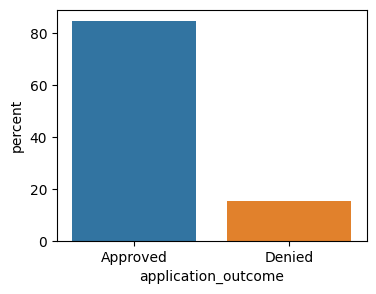

In [12]:
print(f'{df["application_outcome"].value_counts(normalize=True)}')

f, ax = plt.subplots(figsize=(4, 3))
sns.countplot(
    df, x="application_outcome", stat="percent", hue="application_outcome", ax=ax
)
plt.show()

#### Age of applicant and co-applicant

In [13]:
df["applicant_age"] = df["applicant_age"].replace(
    { "8888": np.nan}
)
df = df.dropna(axis=0, subset="applicant_age")
display(df["applicant_age"].value_counts(dropna=False))

applicant_age
35-44    176687
45-54    155520
55-64    109602
25-34     86380
65-74     57704
>74       23196
<25        2666
Name: count, dtype: int64

In [14]:
df["coapplicant_age"] = df["coapplicant_age"].replace(
    {"9999": "no_coapplicant", "8888": np.nan}
)
df = df.dropna(axis=0, subset="coapplicant_age")
display(df["coapplicant_age"].value_counts(dropna=False))

coapplicant_age
no_coapplicant    305070
35-44              88697
45-54              73271
55-64              52685
25-34              49668
65-74              29394
>74                 9416
<25                 2008
Name: count, dtype: int64

#### Sex of applicant and co-applicant

In [15]:
# 1 - Male
# 2 - Female
# 3 - Information not provided by applicant in mail, internet, or telephone application
# 4 - Not applicable
# 6 - Applicant selected both male and female
display(df["applicant_sex"].value_counts(dropna=False))

applicant_sex
1    371356
2    177838
3     60614
6       388
4        13
Name: count, dtype: int64

In [16]:
# Selecting Male (1), Female (2), not_provided (3); dropping the rest
df["applicant_sex"] = df["applicant_sex"].map(
    {1: "Male", 2: "Female", 3: "not_provided"}
)
df = df.dropna(axis=0, subset="applicant_sex")
display(df["applicant_sex"].value_counts(dropna=False))

applicant_sex
Male            371356
Female          177838
not_provided     60614
Name: count, dtype: int64

In [17]:
# 1 - Male
# 2 - Female
# 3 - Information not provided by applicant in mail, internet, or telephone application
# 4 - Not applicable
# 5 - no co-applicant
# 6 - Applicant selected both male and female
display(df["coapplicant_sex"].value_counts())

coapplicant_sex
5    304429
2    197729
1     73393
3     33598
4       479
6       180
Name: count, dtype: int64

In [18]:
# Selecting Male (1), Female (2), not_provided (3), no_coapplicant (5)
df["coapplicant_sex"] = df["coapplicant_sex"].map(
    {1: "Male", 2: "Female", 3: "not_provided", 5: "no_coapplicant"}
)
df = df.dropna(axis=0, subset="coapplicant_sex")
display(df["coapplicant_sex"].value_counts())

coapplicant_sex
no_coapplicant    304429
Female            197729
Male               73393
not_provided       33598
Name: count, dtype: int64

#### Loan details

##### `loan_type`

In [19]:
# 1 - Conventional (not insured or guaranteed by FHA, VA, RHS, or FSA)
# 2 - Federal Housing Administration insured (FHA)
# 3 - Veterans Affairs guaranteed (VA)
# 4 - USDA Rural Housing Service or Farm Service Agency guaranteed (RHS or FSA)
display(df["loan_type"].value_counts())

loan_type
1    571472
2     22381
3     15120
4       176
Name: count, dtype: int64

In [20]:
# Loan type - keeping 1/2/3
df["loan_type"] = df["loan_type"].map({1: "Conventional", 2: "FHA", 3: "VA"})
df = df.dropna(axis=0, subset="loan_type")
display(df["loan_type"].value_counts())

loan_type
Conventional    571472
FHA              22381
VA               15120
Name: count, dtype: int64

##### `purchaser_type`

In [21]:
# 0 - Not applicable
# 1 - Fannie Mae
# 2 - Ginnie Mae
# 3 - Freddie Mac
# 4 - Farmer Mac
# 5 - Private securitizer
# 6 - Commercial bank, savings bank, or savings association
# 71 - Credit union, mortgage company, or finance company
# 72 - Life insurance company
# 8 - Affiliate institution
# 9 - Other type of purchaser
df["purchaser_type"] = df["purchaser_type"].map(
    {
        0: "not_applicable",
        1: "GSE",
        2: "GSE",
        3: "GSE",
        4: "Farmer Mac",
        5: "Private",
        6: "Bank",
        71: "CU/MC/FC",
        72: "LifeInsurance",
        8: "Affiliate",
        9: "Other",
    }
)
display(df["purchaser_type"].value_counts(dropna=False))

purchaser_type
GSE               259886
not_applicable    250782
CU/MC/FC           44500
Bank               31334
Private             9357
Other               8403
Affiliate           2680
LifeInsurance       2030
Farmer Mac             1
Name: count, dtype: int64

In [22]:
# Keeping not_applicable (0), GSE (1+2+3), Private (5), Bank (6), CU/MC/FC (71), LifeInsurance (72), Affiliate (8); dropping 9 and 4
df = df[(df["purchaser_type"] != "Farmer Mac") & (df["purchaser_type"] != "Other")]
display(df["purchaser_type"].value_counts(dropna=False))

purchaser_type
GSE               259886
not_applicable    250782
CU/MC/FC           44500
Bank               31334
Private             9357
Affiliate           2680
LifeInsurance       2030
Name: count, dtype: int64

##### `loan_purpose`

In [23]:
# Description: The purpose of covered loan or application
# Values:
# 1 - Home purchase
# 2 - Home improvement
# 31 - Refinancing
# 32 - Cash-out refinancing
# 4 - Other purpose
# 5 - Not applicable
df["loan_purpose"] = df["loan_purpose"].map(
    {
        1: "Home purchase",
        2: "Home improvement",
        31: "Refinancing",
        32: "Cash-out refinancing",
        4: "Other",
        5: "not_applicable",
    }
)
display(df["loan_purpose"].value_counts())

loan_purpose
Refinancing             280118
Home purchase           129186
Cash-out refinancing    120038
Home improvement         37312
Other                    33833
not_applicable              82
Name: count, dtype: int64

In [24]:
# Dropping `not_applicable`
df = df[df["loan_purpose"] != "not_applicable"]
display(df["loan_purpose"].value_counts(dropna=False))

loan_purpose
Refinancing             280118
Home purchase           129186
Cash-out refinancing    120038
Home improvement         37312
Other                    33833
Name: count, dtype: int64

##### `lien_status`

In [25]:
# Description: Lien status of the property securing the covered loan, or in the case of an application, proposed to secure the covered loan
# Values:
# 1 - Secured by a first lien
# 2 - Secured by a subordinate lien
df["lien_status"] = df["lien_status"].map(
    {
        1: "First",
        2: "Subordinate",
    }
)
display(df["lien_status"].value_counts(dropna=False))

lien_status
First          524329
Subordinate     76158
Name: count, dtype: int64

##### `business_or_commercial_purpose`

In [26]:
# Description: Whether the covered loan or application is primarily for a business or commercial purpose
# Values:
# 1 - Primarily for a business or commercial purpose
# 2 - Not primarily for a business or commercial purpose
# 1111 - Exempt
display(df["business_or_commercial_purpose"].value_counts(dropna=False))

business_or_commercial_purpose
2       578917
1        20160
1111      1410
Name: count, dtype: int64

In [27]:
# Dropping Exempt
df["business_or_commercial_purpose"] = df["business_or_commercial_purpose"].map(
    {1: "Yes", 2: "No"}
)
df = df.dropna(axis=0, subset="business_or_commercial_purpose")
display(df["business_or_commercial_purpose"].value_counts(dropna=False))

business_or_commercial_purpose
No     578917
Yes     20160
Name: count, dtype: int64

#### Race and ethnicity

##### `applicant_race`

In [28]:
display(df["applicant_race"].value_counts(dropna=False))

applicant_race
White             240337
Asian             184994
not_provided      136876
Black              29430
NA/PI               7253
NaN                  149
not_applicable        38
Name: count, dtype: int64

In [29]:
df = df.dropna(axis=0, subset="applicant_race")
df = df[df["applicant_race"] != "not_applicable"]
display(df["applicant_race"].value_counts(dropna=False))

applicant_race
White           240337
Asian           184994
not_provided    136876
Black            29430
NA/PI             7253
Name: count, dtype: int64

##### `coapplicant_race`

In [30]:
display(df["coapplicant_race"].value_counts(dropna=False))

coapplicant_race
no_coapplicant    299161
White             124249
Asian              88603
not_provided       74364
Black               9092
NA/PI               3377
NaN                   23
not_applicable        21
Name: count, dtype: int64

In [31]:
df = df.dropna(axis=0, subset="coapplicant_race")
df = df[df["coapplicant_race"] != "not_applicable"]
display(df["coapplicant_race"].value_counts(dropna=False))

coapplicant_race
no_coapplicant    299161
White             124249
Asian              88603
not_provided       74364
Black               9092
NA/PI               3377
Name: count, dtype: int64

##### `applicant_ethnicity`

In [32]:
display(df["applicant_ethnicity"].value_counts(dropna=False))

applicant_ethnicity
Not Hispanic/Latino    412110
not_provided           127295
Hispanic/Latino         59098
NaN                       305
not_applicable             38
Name: count, dtype: int64

In [33]:
df = df.dropna(axis=0, subset="applicant_ethnicity")
df = df[df["applicant_ethnicity"] != "not_applicable"]
display(df["applicant_ethnicity"].value_counts(dropna=False))

applicant_ethnicity
Not Hispanic/Latino    412110
not_provided           127295
Hispanic/Latino         59098
Name: count, dtype: int64

##### `coapplicant_ethnicity`

In [34]:
display(df["coapplicant_ethnicity"].value_counts(dropna=False))

coapplicant_ethnicity
no_coapplicant         298785
Not Hispanic/Latino    200587
not_provided            69800
Hispanic/Latino         29296
NaN                        25
not_applicable             10
Name: count, dtype: int64

In [35]:
df = df.dropna(axis=0, subset="coapplicant_ethnicity")
df = df[df["coapplicant_ethnicity"] != "not_applicable"]
display(df["coapplicant_ethnicity"].value_counts(dropna=False))

coapplicant_ethnicity
no_coapplicant         298785
Not Hispanic/Latino    200587
not_provided            69800
Hispanic/Latino         29296
Name: count, dtype: int64

#### Other

##### `derived_loan_product_type`

In [36]:
display(df["derived_loan_product_type"].value_counts(dropna=False))

derived_loan_product_type
Conventional:First Lien          486170
Conventional:Subordinate Lien     75844
FHA:First Lien                    21470
VA:First Lien                     14947
FHA:Subordinate Lien                 36
VA:Subordinate Lien                   1
Name: count, dtype: int64

In [37]:
df = df[(df["derived_loan_product_type"] != "FHA:Subordinate Lien") | (df["derived_loan_product_type"] != "VA:Subordinate Lien")]
display(df["derived_loan_product_type"].value_counts())

derived_loan_product_type
Conventional:First Lien          486170
Conventional:Subordinate Lien     75844
FHA:First Lien                    21470
VA:First Lien                     14947
FHA:Subordinate Lien                 36
VA:Subordinate Lien                   1
Name: count, dtype: int64

##### `construction_method`

In [38]:
# Description: Construction method for the dwelling
# Values:
# 1 - Site-built
# 2 - Manufactured home
display(df["construction_method"].value_counts(dropna=False))
# keeping only site-built constrution method and dropping the column
df = df[df["construction_method"] == 1]
df = df.drop("construction_method", axis=1)

construction_method
1    595980
2      2488
Name: count, dtype: int64

##### `total_units`

In [39]:
display(df["total_units"].value_counts(dropna=False))

total_units
1        484746
1         95759
2          7840
4          2710
3          2154
2          1353
5-24        550
4           457
3           377
25-49        28
50-99         6
Name: count, dtype: int64

In [40]:
# keeping only 1-4 units and dropping the column
df["total_units"] = (
    df["total_units"]
    .astype(str)
    .map(lambda x: "1-4" if int(x.split("-")[0]) <= 4 else "5+")
)
display(df["total_units"].value_counts(dropna=False))
df = df[df["total_units"] == "1-4"]
df = df.drop("total_units", axis=1)

total_units
1-4    595396
5+        584
Name: count, dtype: int64

##### `derived_dwelling_category`

In [41]:
# this column is based on the previous 2, so now can be dropped
display(df["derived_dwelling_category"].value_counts(dropna=False))
df = df.drop("derived_dwelling_category", axis=1)

derived_dwelling_category
Single Family (1-4 Units):Site-Built    595396
Name: count, dtype: int64

##### `open-end_line_of_credit`

In [42]:
display(df["open-end_line_of_credit"].value_counts(dropna=False))
df["open-end_line_of_credit"] = df["open-end_line_of_credit"].map({1: "Yes", 2: "No"})
display(df["open-end_line_of_credit"].value_counts(dropna=False))

open-end_line_of_credit
2    516193
1     79203
Name: count, dtype: int64

open-end_line_of_credit
No     516193
Yes     79203
Name: count, dtype: int64

##### `hoepa_status`

In [43]:
# Description: Whether the covered loan is a high-cost mortgage
# Values:
# 1 - High-cost mortgage
# 2 - Not a high-cost mortgage
# 3 - Not applicable
df["hoepa_status"] = df["hoepa_status"].map(
    {
        1: "High-cost",
        2: "No",
        3: "not_applicable",
    }
)
display(df["hoepa_status"].value_counts(dropna=False))

hoepa_status
No                466500
not_applicable    128748
High-cost            148
Name: count, dtype: int64

In [44]:
# dropping high-cost
df = df[df["hoepa_status"] != "High-cost"]
display(df["hoepa_status"].value_counts(dropna=False))

hoepa_status
No                466500
not_applicable    128748
Name: count, dtype: int64

##### `reverse_mortgage`

In [45]:
display(df["reverse_mortgage"].value_counts(dropna=False))
# dropping this column
df = df.drop("reverse_mortgage", axis=1)

reverse_mortgage
2       590715
1         4532
1111         1
Name: count, dtype: int64

##### `interest_only_payment`

In [46]:
display(df["interest_only_payment"].value_counts(dropna=False))
df["interest_only_payment"] = df["interest_only_payment"].map({1: "Yes", 2: "No"})
df = df.dropna(axis=0, subset="interest_only_payment")  # dropping Exempt (1111)

interest_only_payment
2       548310
1        46195
1111       743
Name: count, dtype: int64

##### `balloon_payment`

In [47]:
display(df["balloon_payment"].value_counts())
df = df.drop("balloon_payment", axis=1)  # dropping

balloon_payment
2    593527
1       978
Name: count, dtype: int64

##### `occupancy_type`

In [48]:
display(df["occupancy_type"].value_counts())
df["occupancy_type"] = df["occupancy_type"].map(
    {1: "Main residence", 2: "Second residence", 3: "Investment property"}
)

occupancy_type
1    549686
3     40242
2      4577
Name: count, dtype: int64

### Check-point: check null values

Here I check the columns for how many null values they have to decide what will be done.

In [49]:
for col in df.columns:
    is_null = df[col].isnull().sum()
    if is_null > 0:
        print(col, is_null)

loan_to_value_ratio 18730
interest_rate 90644
rate_spread 118812
total_loan_costs 164452
total_points_and_fees 591806
origination_charges 162956
discount_points 460143
lender_credits 381418
loan_term 5633
prepayment_penalty_term 564863
intro_rate_period 465413
property_value 11191
multifamily_affordable_units 594505
income 19236
debt_to_income_ratio 25044
co-applicant_age_above_62 296818


The features that have a lot of missing values and cannot be rebuilt will be dropped.

In [50]:
df = df.drop(
    [
        "total_loan_costs",
        "total_points_and_fees",
        "origination_charges",
        "discount_points",
        "lender_credits",
        "prepayment_penalty_term",
        "intro_rate_period",
        "multifamily_affordable_units",
        "co-applicant_age_above_62",
        "interest_rate",
        "rate_spread",
    ],
    axis=1,
    errors="ignore",
)

In [51]:
for col in df.columns:
    is_null = df[col].isnull().sum()
    if is_null > 0:
        print(col, is_null)

loan_to_value_ratio 18730
loan_term 5633
property_value 11191
income 19236
debt_to_income_ratio 25044


The features `loan_term`, `property_value` and `income` are important, so all rows with null values will be dropped.

In [52]:
df = df.dropna(axis=0, subset=["loan_term", "property_value", "income"])

for col in df.columns:
    is_null = df[col].isnull().sum()
    if is_null > 0:
        print(col, is_null)

loan_to_value_ratio 2156
debt_to_income_ratio 2903


Finally, I will drop the remaining rows with null values:

In [53]:
for col in df.columns:
    is_null = df[col].isnull().sum()
    if is_null > 0:
        print(col, is_null)

loan_to_value_ratio 2156
debt_to_income_ratio 2903


In [54]:
df = df.dropna()

In [55]:
print(df.shape)
for col in df.columns:
    is_null = df[col].isnull().sum()
    if is_null > 0:
        print(col, is_null)

(558161, 37)


### More transformations and filters

#### `loan_term`

- converting from months to years

In [56]:
df["loan_term"] = pd.to_numeric(df["loan_term"]) / 12

#### `loan_amount`

- limiting from 10k to 3kk USD

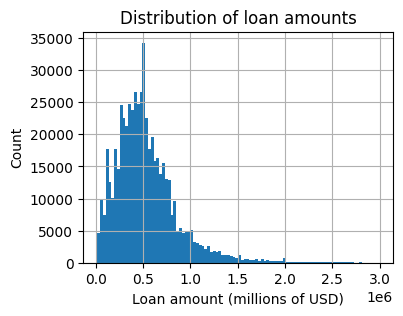

In [57]:
f, ax = plt.subplots(figsize=(4, 3))
df[(df["loan_amount"] > 1e4) & (df["loan_amount"] < 3e6)]["loan_amount"].hist(
    bins=100, ax=ax
)
plt.ylabel("Count")
plt.xlabel("Loan amount (millions of USD)")
plt.title("Distribution of loan amounts")
plt.show()

In [58]:
df = df[(df["loan_amount"] > 1e4) & (df["loan_amount"] < 2e6)]

#### `property_value`

- above 100k and below 4kk USD

In [59]:
df["property_value"] = pd.to_numeric(df["property_value"])

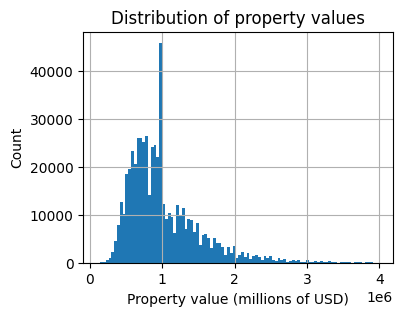

In [60]:
f, ax = plt.subplots(figsize=(4, 3))
df[(df["property_value"] >= 100e3) & (df["property_value"] < 4e6)][
    "property_value"
].hist(bins=100, ax=ax)
plt.ylabel("Count")
plt.xlabel("Property value (millions of USD)")
plt.title("Distribution of property values")
plt.show()

In [61]:
df = df[(df["property_value"] >= 100e3) & (df["property_value"] < 4e6)]

#### `income`

- convert to millions of USD
- limiting from above 10k USD and below 2kk USD

In [62]:
df["income"] *= 1000

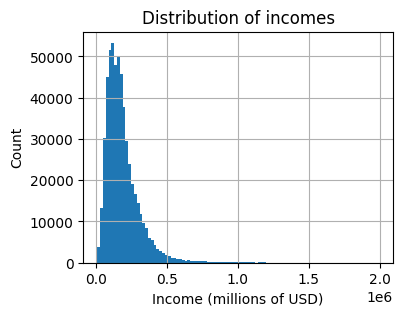

In [63]:
f, ax = plt.subplots(figsize=(4, 3))
df[(df["income"] > 10e3) & (df["income"] < 2e6)]["income"].hist(bins=100, ax=ax)
plt.ylabel("Count")
plt.xlabel("Income (millions of USD)")
plt.title("Distribution of incomes")
plt.show()

In [64]:
df = df[(df["income"] > 10e3) & (df["income"] < 1e6)]

#### `loan_to_value_ratio`

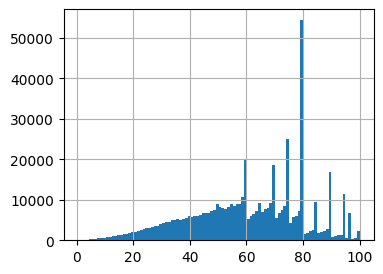

In [65]:
df["loan_to_value_ratio"] = pd.to_numeric(df["loan_to_value_ratio"])
df = df[df["loan_to_value_ratio"] <= 100.0]  # almost all values are <100%

f, ax = plt.subplots(figsize=(4, 3))
df["loan_to_value_ratio"].hist(bins=100, ax=ax)
plt.show()

#### `debt_to_income_ratio`

In [66]:
df['debt_to_income_ratio'] = df['debt_to_income_ratio'].replace({
    '<20%': 18,
    '20%-<30%': 25,
    '30%-<36%': 33,
    '50%-60%': 55,
    '>60%': 70,
}).apply(lambda x: float(x)/100)

#### `debt_to_income_ratio_df`

debt_to_income_ratio_df
(-7.07e-05, 0.15]    400985
(0.15, 0.3]          139424
(0.3, 0.45]            4292
(0.45, 0.599]          1068
Name: count, dtype: int64

debt_to_income_ratio_df
(-0.000472, 0.077]    136470
(0.077, 0.115]        136494
(0.115, 0.153]        136386
(0.153, 0.599]        136419
Name: count, dtype: int64

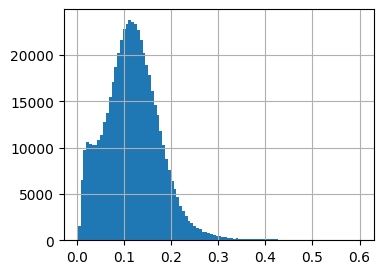

In [67]:
# Defining with the values of the dataset
df["debt_to_income_ratio_df"] = (df["loan_amount"] / (df["loan_term"])) / df["income"]

test_cuts(df, "debt_to_income_ratio_df", 0.6, n=4)

f, ax = plt.subplots(figsize=(4, 3))
df[df["debt_to_income_ratio_df"] <= 0.6]["debt_to_income_ratio_df"].hist(bins=100, ax=ax)
plt.show()

In [68]:
# Removing very large values
df = df[df["debt_to_income_ratio_df"] < 0.5]

#### tract features

In [69]:
df = df[(df["tract_population"] > 0) & (df["tract_population"] < 30000)]
df["tract_population"] = pd.to_numeric(df["tract_population"])

df = df[df["tract_to_msa_income_percentage"] > 0]

df["tract_median_age_of_housing_units"] = pd.to_numeric(
    df["tract_median_age_of_housing_units"]
)
df["tract_median_age_of_housing_units"] = (
    df["tract_median_age_of_housing_units"].astype(float) / 10
).astype(int)

for c in [x for x in df.columns if x.startswith("tract") or x.startswith("ffiec")]:
    df[c] = pd.to_numeric(df[c]).astype(float)

## Exporting pre-processed data

In [70]:
order = {np.dtype("float64"): 0, np.dtype("object"): 1}
df = df[df.dtypes.map(order).sort_values().index]

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 544844 entries, 0 to 616367
Data columns (total 38 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   debt_to_income_ratio_df            544844 non-null  float64
 1   property_value                     544844 non-null  float64
 2   loan_term                          544844 non-null  float64
 3   loan_to_value_ratio                544844 non-null  float64
 4   loan_amount                        544844 non-null  float64
 5   income                             544844 non-null  float64
 6   tract_minority_population_percent  544844 non-null  float64
 7   tract_to_msa_income_percentage     544844 non-null  float64
 8   tract_population                   544844 non-null  float64
 9   tract_one_to_four_family_homes     544844 non-null  float64
 10  tract_median_age_of_housing_units  544844 non-null  float64
 11  tract_owner_occupied_units         544844 no

In [72]:
df["application_outcome"].value_counts(normalize=True)

application_outcome
Approved    0.862342
Denied      0.137658
Name: proportion, dtype: float64

In [73]:
df.reset_index(drop=True).to_csv(f"../../{filename_output}.csv")